In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import math

In [148]:
def generate_problem(m,n):
    rand = np.random.default_rng(seed=1)
    return rand.normal(size=(m,n)), np.zeros((n,))[np.newaxis].T

def sum_func(n, f):
    acc = 0 
    for i in range(n):
        acc += f(i)
    return acc

def gen_f(A):
    m, n = A.shape
    return lambda xk: -sum_func(m, lambda j: math.log(1 - (A[j,:] @ xk).item())) \
                      -sum_func(n, lambda i: math.log(1 + xk.flatten()[i])) \
                      -sum_func(n, lambda i: math.log(1 - xk.flatten()[i]))

def gen_df(A):
    m, n = A.shape
    return lambda xk: sum_func(m, lambda j: A[j,:] / (1 - A[j,:] @ xk))[np.newaxis].T \
                      -np.vectorize(lambda xi: 1 / (1 + xi))(xk) \
                      +np.vectorize(lambda xi: 1 / (1 - xi))(xk)
    
def gen_hf(A):
    m, n = A.shape
    return lambda xk: sum_func(m, lambda j: A[j,:][np.newaxis].T @ A[j,:][np.newaxis] / ((1 - A[j,:] @ xk) ** 2)) \
                     +np.diag(np.vectorize(lambda xi: 1 / ((1 + xi) ** 2))(xk)) \
                     +np.diag(np.vectorize(lambda xi: 1 / ((1 - xi) ** 2))(xk))

In [149]:
delta = 0.01
def gen_stepsize(A, sigma, beta, f, df):
    def helper(dk, xk):
        s = 1
        alpha = s 
        while np.any(A @ (xk + alpha * dk) >= 1) or \
        np.any(np.abs(xk + alpha * dk) >= 1) or \
        f(xk + alpha * dk) - f(xk) >= sigma * alpha * df(xk).T @ dk:
            alpha *= beta
        return alpha
    return helper
epsilon = 1e-3
stopcond = lambda xk, df: np.linalg.norm(df(xk),ord=2) <= epsilon

sigmas = [1/10, 1/5, 1/3, 1/2]
betas = [1/4, 1/3, 1/2, 3/4]
ms = [20, 30, 40, 50]
ns = [10, 20, 30, 40]

In [150]:

# Run each stepsize, stopcond pair, storing data necessary for plotting
np.seterr(all='raise')
plotdata_steepest = {}
for sigma in tqdm(sigmas):
    for beta in tqdm(betas, leave=False):
        for m in tqdm(ms, leave=False):
            for n in tqdm(ns, leave=False):
                k = 0
                A, x0 = generate_problem(m, n)
                f = gen_f(A)
                df = gen_df(A)
                hf = gen_hf(A)
                stepsize = gen_stepsize(A, sigma, beta, f, df)
                curalg = (sigma, beta, m, n)
                plotdata_steepest.update({curalg: []})
                xk = x0
                while True:
                    plotdata_steepest[curalg].append(f(xk))
                    grad = df(xk)
                    try:
                        L = np.linalg.cholesky(hf(xk))
                        dk = -np.linalg.inv(hf(xk)) @ grad
                    except:
                        dk = -grad
                    step = stepsize(dk, xk)
                    if stopcond(xk, df):
                        break
                    k += 1
                    xk = xk + step * dk

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

-0.8421402294377032

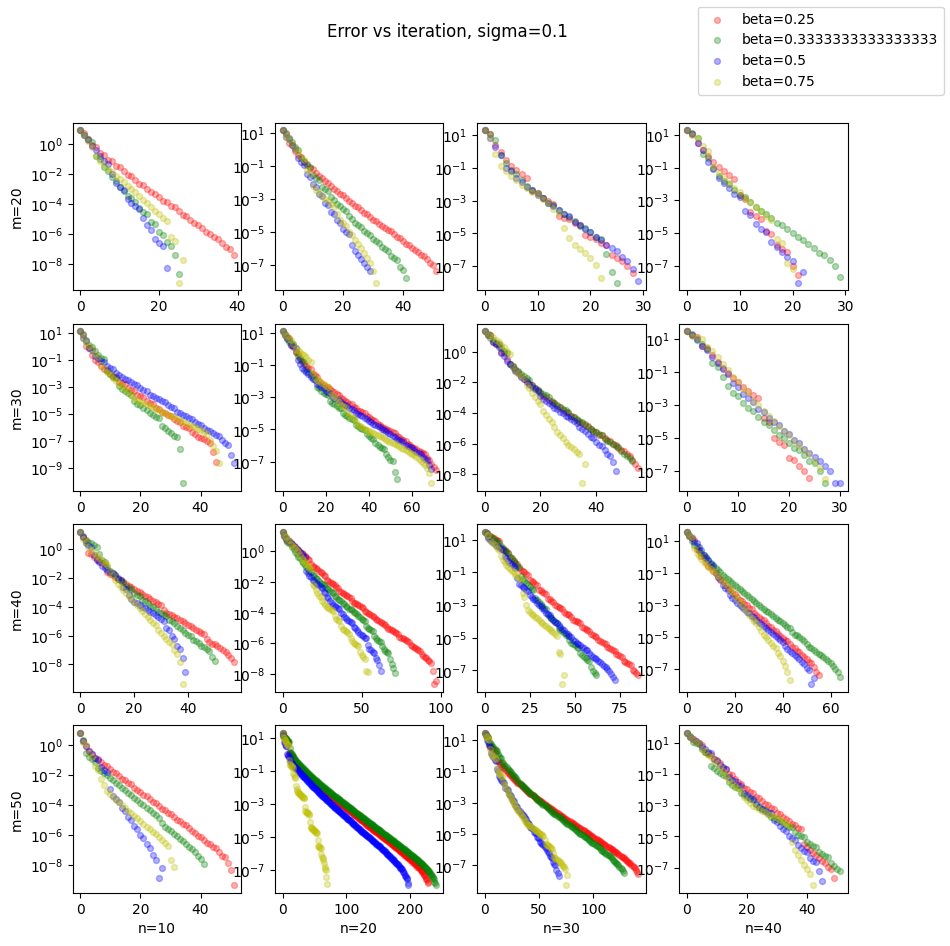

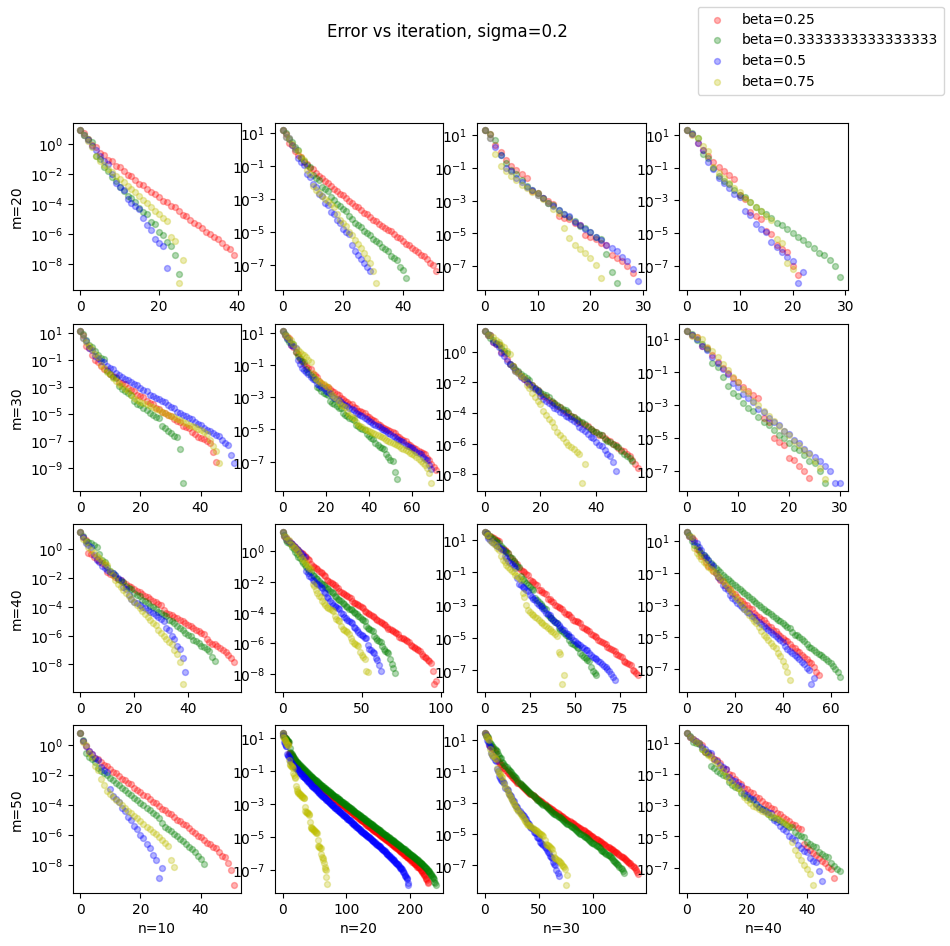

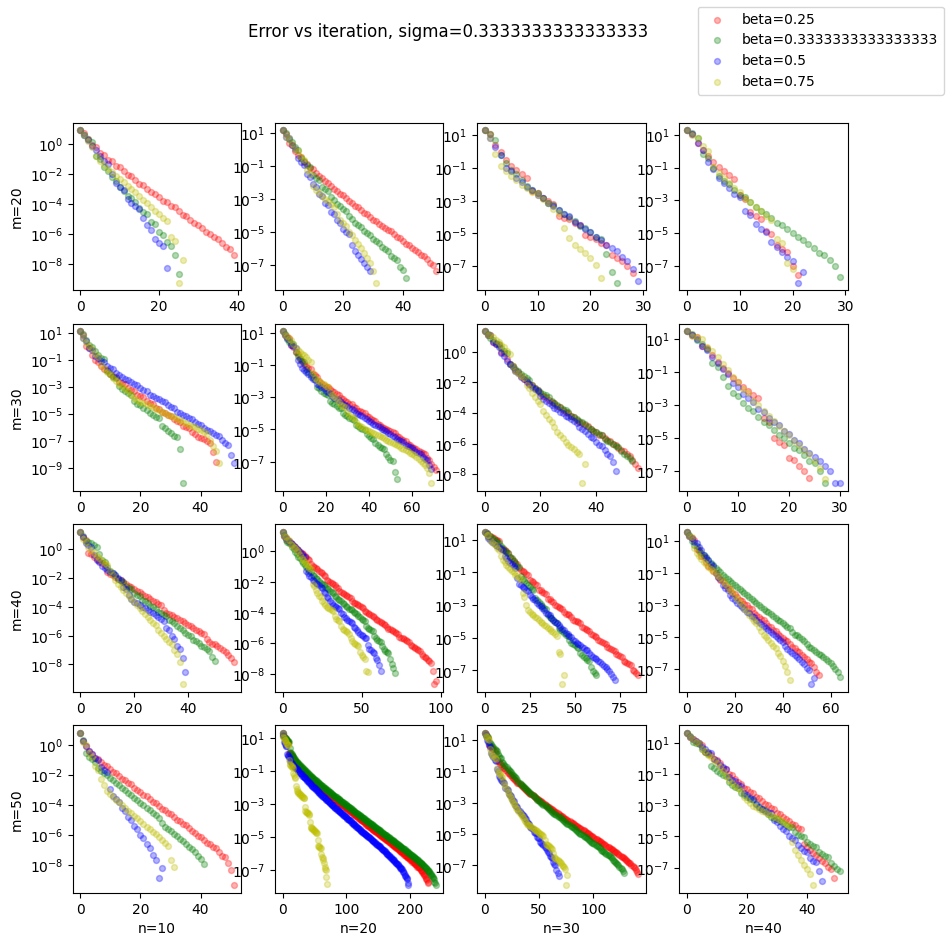

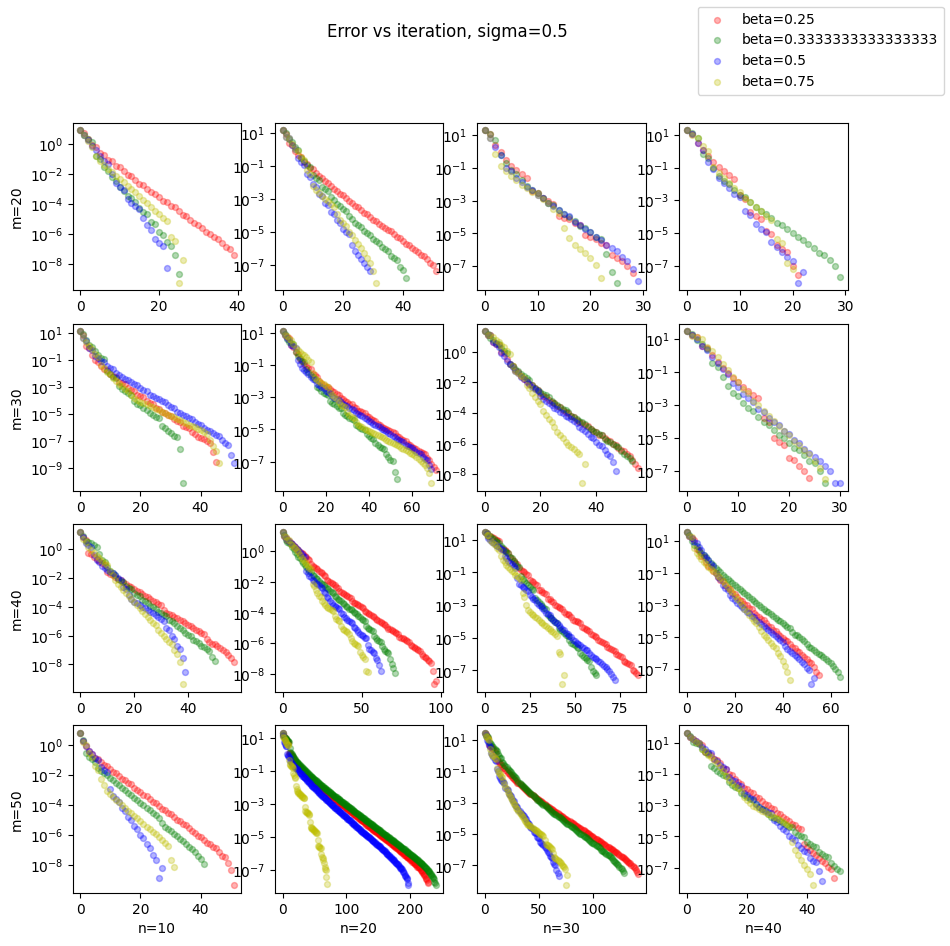

In [135]:
colors = ['r', 'g', 'b', 'y']
def data_graph(plotname, sigma):
    fig, axs = plt.subplots(4,4, figsize=(10,10))
    for i, m in enumerate(ms):
        for j, n in enumerate(ns):
            # select xstar as average over all values of this 
            xstar = 0
            for beta in betas:
                for sigma in sigmas:
                    alg = (sigma, beta, m, n)
                    xstar += plotdata_steepest[alg][-1]
            xstar /= 16
            for k, beta in enumerate(betas):
                alg = (sigma, beta, m, n)
                y = abs(np.array(plotdata_steepest[alg]) - xstar)
                x = range(len(plotdata_steepest[alg]))
                axs[i,j].scatter(x, y, c=colors[k], label=f"beta={beta}",s=plt.rcParams['lines.markersize'] ** 2 * 2, marker = '.', alpha=0.3)
            if j == 0:
                axs[i,j].set(ylabel=f"m={m}")
            if i == 3:
                axs[i,j].set(xlabel=f"n={n}")
            axs[i,j].set_yscale("log")
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc="upper right")
    fig.suptitle(plotname)
for sigma in sigmas:
    data_graph(f"Error vs iteration, sigma={sigma}", sigma)

(10, 10)

In [142]:
A[1,:][np.newaxis].T @ A[1,:][np.newaxis]

array([[ 0.00080782,  0.01553881, -0.02093168, -0.00463027, -0.01370291,
         0.01702055,  0.00112899, -0.00831228, -0.02222359, -0.00730998],
       [ 0.01553881,  0.29889509, -0.40262901, -0.08906498, -0.26358089,
         0.327397  ,  0.02171659, -0.1598899 , -0.42747951, -0.14061034],
       [-0.02093168, -0.40262901,  0.54236462,  0.1199757 ,  0.35505874,
        -0.44102274, -0.02925351,  0.21538097,  0.57583968,  0.18941028],
       [-0.00463027, -0.08906498,  0.1199757 ,  0.02653965,  0.07854203,
        -0.09755801, -0.00647113,  0.04764411,  0.12738067,  0.04189917],
       [-0.01370291, -0.26358089,  0.35505874,  0.07854203,  0.23243903,
        -0.28871532, -0.0191508 ,  0.14099905,  0.37697317,  0.12399735],
       [ 0.01702055,  0.327397  , -0.44102274, -0.09755801, -0.28871532,
         0.35861679,  0.02378743, -0.17513662, -0.46824292, -0.1540186 ],
       [ 0.00112899,  0.02171659, -0.02925351, -0.00647113, -0.0191508 ,
         0.02378743,  0.00157785, -0.011617  